Sử dụng thuật toán di truyền để tìm trọng số cho mạng nơ ron tế bào cho bài toán tìm biên ảnh.
Một số lưu ý trong quá trình code:
- Do hàm giải phương trình vi phân (ODE) chỉ nhận mảng 1 chiều (array) vào giá trị ban đầu cũng như đầu ra của x nên phải biến đổi từ dạng ma trận về mảng 1 chiều ở một số phép tính.
- Thứ tự của m, n (kích thước của ma trận đầu vào) đôi khi bị ngược nhau trong quá trình reshape. Lưu ý khi đưa vào ma trận không vuông.
- Các số dùng trong phép tính nên để ở dạng float

In [1]:
from numba import jit, cuda 
from scipy.signal import convolve2d
from scipy.integrate import ode
import numpy as np
from PIL import Image as img

In [2]:
# hàm trạng thái
def hamTrangThai(t, x, u, B, A, I, n, m):
    x = x.reshape(n, m)
    dx = -x + convolve2d(u, B, 'same') + convolve2d(hamDauRa(x), A, 'same') + I
    return dx.reshape(n*m)

# hàm đầu ra
def hamDauRa(x):
    return 0.5 * (np.abs(x + 1) - np.abs(x - 1))

# Tạo ma trận đối xứng từ 5 trọng số (hàm này chỉ dành riêng cho ma trận đối xứng 3x3)
def taoMaTranDoiXung(arr1):#giả sử cho mảng [1,2,3,4,5]
    arr2 = arr1[-2::-1].copy()#tạo mảng phụ [4,3,2,1]
    #arr2[0], arr2[2] = arr2[2], arr2[0]#nếu có thì sẽ đối xứng theo đường chéo phụ, nếu không thì sẽ là đối xứng tâm
    return np.append(arr1,arr2).reshape(h,h)#kết hợp hai mảng rồi chuyển về dạng ma trận 3x3

# Hàm lai hai số
def lai(a,b):#k là điểm lai  -3,|45
    if(a>0):
        return np.round(a//1+np.abs(b)-np.abs(b)//1,2)
    else:
        return np.round(a//1-np.abs(b)+np.abs(b)//1,2)

# Hàm tạo số ngẫu nhiên từ -9.99 đến 9.99
def ngauNhien():
    return np.random.randint(-999,1000)/100.

# Hàm tính sai số
def saiSo(d,y):
    return np.sum(0.5*(d-y)**2)

def loadSample(path):
    return np.array(img.open(path).convert('RGB'), dtype=float)[:,:,0]/255.0*2.0-1.0

# Bán kính lân cận của nơ ron tế bào
r = 1

# kích thước của ma trận điều khiển và ma trận phản hồi (hai ma trận này luôn vuông)
h = 2*r + 1 # h = 3

class CNN:

    slts = 11 # số lượng trọng số trong quần thể

    # Quần thể trọng số (gồm 11 số)
    #quanThe = np.array([ngauNhien() for i in range(slts)])
    quanThe = np.array([0.,0.,0.,0.,2.,0.,0.,0.,0.,0.,1.])

    # ma trận ảnh đầu vào u
    #u = np.array(img.open('images/u1b.png').convert('RGB'), dtype=float)[:,:,0]/255.0*2.0-1.0
    u = [
        loadSample('images/u1_1.png'),
        loadSample('images/u1_2.png'),
        loadSample('images/u1_3.png'),
        loadSample('images/u1_4.png'),
        loadSample('images/u1_5.png'),
    ]

    # kích thước ma trận đầu vào, ma trận đầu ra và ma trận trạng thái
    m, n = u[0].shape
    print(m,n)

    # ma trận đầu ra mong muốn d
    #d = np.array(img.open('images/d1b.png').convert('RGB'), dtype=float)[:,:,0]/255.0*2.0-1.0
    d = [
        loadSample('images/d1_1.png'),
        loadSample('images/d1_2.png'),
        loadSample('images/d1_3.png'),
        loadSample('images/d1_4.png'),
        loadSample('images/d1_5.png'),
    ]

    # ma trận điều khiển B ban đầu
    B = taoMaTranDoiXung(quanThe[5:10])

    # ma trận phản hồi A ban đầu
    A = taoMaTranDoiXung(quanThe[:5])

    # mức ngưỡng I ban đầu
    I = quanThe[10]
    #I = -1.0

    # hai giá trị ban đầu cho ptvp gồm x0 = [ma trận toàn số 0] với t0 = 0.0 và t1 để tính đầu ra x1 (t1 != t0)
    x0, t0, t1 = [i.copy() for i in u], 0., 0.05

    # ma trận đầu ra y (y được tính theo x)
    y = [hamDauRa(i) for i in x0]

    # sai số cho phép
    E0 = 2.*len(u)

    # sai số hiện tại
    E = [float('inf')]*len(u) # mặc định ban đầu gán với dương vô cùng

cnn = CNN()

# Hàm tối ưu trọng số thứ i trong quần thể
def toiUuTrongSo(i, k, soChaMe): #k là lần chạy thứ k của vòng lặp lớn
    tapChaMe = [[ngauNhien(),ngauNhien()] for i in range(soChaMe)]
    # tapChaMe = [[i,i] for i in range(-9,10)]
    tapCon = [lai(chaMe[0],chaMe[1]) for chaMe in tapChaMe]
    if(k == 1):
        print(f'Tập cha mẹ: {tapChaMe}')
        print(f'Tập con: {tapCon}')
        print('Xét từng cặp cha mẹ:')
    for con in tapCon:
        quanTheMoi = cnn.quanThe.copy()
        quanTheMoi[i] = con
        ACon = taoMaTranDoiXung(quanTheMoi[:5])
        BCon = taoMaTranDoiXung(quanTheMoi[5:10])
        ICon = quanTheMoi[10]
        ECon = []
        yCon = []
        for i in range(len(cnn.u)):
            #print(f'x[{i}] = \n{cnn.x0[i]}')
            #print(f'u[{i}] = \n{cnn.u[i]}')
            ptvp[i] = ptvp[i].set_initial_value(cnn.x0[i].flatten(), cnn.t0)
            ptvp[i] = ptvp[i].set_f_params(cnn.u[i], BCon, ACon, ICon, cnn.n, cnn.m)
            x = (ptvp[i].integrate(cnn.t1)).reshape(cnn.n, cnn.m)
            y = np.sign(hamDauRa(x))
            #print(f'y[{i}] = \n{y}')
            yCon.append(y)
            ECon.append(saiSo(cnn.d[i],y))
        if(k == 1):
            print(f'Sai số ứng với con = {con} là: E = {ECon}, tổng sai số: {sum(ECon)}')
        if(sum(ECon) <= sum(cnn.E)):
            cnn.y = yCon.copy()
            #cnn.u = xCon.copy()
            cnn.quanThe = quanTheMoi.copy()
            cnn.E = ECon
            cnn.A = ACon.copy()
            cnn.B = BCon.copy()
            cnn.I = ICon

# khởi tạo phương trình vi phân
ptvp = [ode(hamTrangThai).set_integrator('vode')]*len(cnn.u) # thuật toán được sử dụng để giải ptvp, đọc thêm trong tài liệu

print(f'A = {cnn.A}')
print(f'B = {cnn.B}')
print(f'I = {cnn.I}')
for i in range(len(cnn.u)):
    print(f'u[{i}] = \n{cnn.u[i]}')
    print(f'd[{i}] = \n{cnn.d[i]}')

for i in range(len(cnn.u)):
    ptvp[i].set_initial_value(cnn.x0[i].flatten(), 0.) # lệnh flatten dùng để biến đổi ma trận về dạng mảng (đầu vào của ode phải là một số hoặc mảng)
    ptvp[i].set_f_params(cnn.u[i], cnn.B, cnn.A, cnn.I, cnn.n, cnn.m)
    assert ptvp[i].successful()
    x = (ptvp[i].integrate(cnn.t1))[:].reshape(cnn.n, cnn.m)
    y = hamDauRa(x)
    cnn.y[i] = np.sign(y)
    print(f'y = {cnn.y[i]}')
    cnn.E[i] = saiSo(cnn.d[i],cnn.y[i])
    print(f'E = {cnn.E[i]}')
print(f'sai số: {cnn.E}. Tổng: {sum(cnn.E)}')

8 8
A = [[0. 0. 0.]
 [0. 2. 0.]
 [0. 0. 0.]]
B = [[0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]]
I = 1.0
u[0] = 
[[ 1.  1.  1. -1.  1.  1. -1. -1.]
 [ 1.  1.  1. -1.  1.  1. -1. -1.]
 [ 1.  1. -1. -1. -1.  1.  1. -1.]
 [ 1.  1. -1. -1. -1.  1.  1.  1.]
 [ 1. -1. -1. -1. -1. -1.  1.  1.]
 [ 1. -1. -1. -1. -1. -1.  1.  1.]
 [-1. -1. -1. -1. -1. -1. -1.  1.]
 [-1. -1. -1. -1. -1. -1. -1.  1.]]
d[0] = 
[[ 1.  1.  1. -1.  1.  1. -1. -1.]
 [ 1.  1.  1. -1.  1.  1. -1. -1.]
 [ 1.  1. -1.  1. -1.  1.  1. -1.]
 [ 1.  1. -1.  1. -1.  1.  1.  1.]
 [ 1. -1.  1.  1.  1. -1.  1.  1.]
 [ 1. -1.  1.  1.  1. -1.  1.  1.]
 [-1.  1.  1.  1.  1.  1. -1.  1.]
 [-1. -1. -1. -1. -1. -1. -1.  1.]]
u[1] = 
[[-1. -1. -1. -1.  1.  1.  1.  1.]
 [-1. -1. -1. -1.  1. -1. -1. -1.]
 [-1. -1. -1. -1.  1. -1. -1. -1.]
 [-1. -1. -1. -1.  1. -1. -1. -1.]
 [ 1.  1.  1.  1.  1.  1.  1.  1.]
 [-1. -1. -1. -1. -1. -1. -1.  1.]
 [-1. -1. -1. -1. -1. -1. -1.  1.]
 [-1. -1. -1. -1. -1. -1. -1.  1.]]
d[1] = 
[[-1. -1. -1. -1.  1.  1.  1.  

In [4]:
print('Bộ trọng số ban đầu: ')
print(f'A = {cnn.A}')
print(f'B = {cnn.B}')
print(f'I = {cnn.I}')
print(f'Tổng sai số ban đầu: {sum(cnn.E)}')
# thuật toán tối ưu từng trọng số theo phương pháp ngẫu nhiên
soChaMe = 20 # số cha mẹ được chọn để lai mới mỗi trọng số 
loop = 500 #số lần chạy thử tối đa
count = 0 # đếm số lần chạy
while(True):
    # kiểm tra ptvp ODE
    if([i.successful() for i in ptvp].count(False)):
        print('Lỗi phương trình vi phân')
        break

    # xét trọng số
    ts = count%cnn.slts # STT trọng số hiện tại đang được lai (trọng số lai)

    # đếm số lần chạy
    if(count>loop*cnn.slts):
        print('Đạt đến số vòng lặp tối đa')
        break
    else:
        print(f'Lần chạy thứ {count//cnn.slts+1}')
        if(ts%cnn.slts==cnn.slts-1):
            print(f'Xét trọng số I')
        else:
            print(f'Xét trọng số thứ {ts%cnn.slts%5+1} của ma trận {"A" if ts%cnn.slts//5==0 else "B"}:')

    toiUuTrongSo(ts, count//cnn.slts+1, soChaMe)

    print(f'Sai số: {cnn.E}. Tổng: {sum(cnn.E)}')
    # kiểm tra sai số
    if(sum(cnn.E) <= cnn.E0):
        print('Đạt đến mức sai số cho phép')
        break

    if(count == 10):
        print(f'A = {cnn.A}')
        print(f'B = {cnn.B}')
        print(f'I = {cnn.I}')

    count+=1

print('Bộ trọng sau khi tối ưu: ')
print(f'A = {cnn.A}')
print(f'B = {cnn.B}')
print(f'I = {cnn.I}')
for i in range(len(cnn.u)):
    print(f'y[{i}] = \n{cnn.y[i]}')

Bộ trọng số ban đầu: 
A = [[ 5.05 -1.06 -1.46]
 [-6.61 -1.77 -6.61]
 [-1.46 -1.06  5.05]]
B = [[-8.67 -2.95 -1.66]
 [ 1.42  5.3   1.42]
 [-1.66 -2.95 -8.67]]
I = 3.42
Tổng sai số ban đầu: 10.0
Lần chạy thứ 1
Xét trọng số thứ 1 của ma trận A:
Tập cha mẹ: [[7.33, -8.99], [-7.46, -1.31], [-1.76, -4.58], [9.46, -1.28], [-1.89, 8.21], [9.44, 8.48], [7.42, 1.52], [4.61, 2.08], [9.76, 8.11], [-7.52, 3.43], [9.99, -9.04], [3.83, 9.26], [-7.98, -6.56], [-9.4, 4.24], [-1.91, -9.93], [-5.31, 9.97], [-7.22, 4.96], [-5.34, 9.42], [0.35, 4.39], [5.77, -6.35]]
Tập con: [7.99, -8.31, -2.58, 9.28, -2.21, 9.48, 7.52, 4.08, 9.11, -8.43, 9.04, 3.26, -8.56, -10.24, -2.93, -6.97, -8.96, -6.42, 0.39, 5.35]
Xét từng cặp cha mẹ:
Sai số ứng với con = 7.99 là: E = [4.0, 0.0, 8.0, 8.0, 2.0], tổng sai số: 22.0
Sai số ứng với con = -8.31 là: E = [6.0, 2.0, 0.0, 6.0, 0.0], tổng sai số: 14.0
Sai số ứng với con = -2.58 là: E = [4.0, 0.0, 0.0, 6.0, 0.0], tổng sai số: 10.0
Sai số ứng với con = 9.28 là: E = [12.0, 6.0, 1

In [5]:
# Lưu lại bộ trọng số
np.savetxt('TrongSoBac1/A.txt',cnn.A)
np.savetxt('TrongSoBac1/B.txt',cnn.B)
np.savetxt('TrongSoBac1/I.txt',np.array([cnn.I]))
print('Đã lưu')

Đã lưu


In [6]:
# kiểm tra lại bộ trọng số

# testA = np.loadtxt('TrongSoBac1ToiUu/TrongSo2/A.txt')
# testB = np.loadtxt('TrongSoBac1ToiUu/TrongSo2/B.txt')
# testI = np.loadtxt('TrongSoBac1ToiUu/TrongSo2/I.txt')
testA = np.loadtxt('TrongSoBac1/A.txt')
testB = np.loadtxt('TrongSoBac1/B.txt')
testI = np.loadtxt('TrongSoBac1/I.txt')
# cnn.u = np.array(img.open('images/u1.png').convert('RGB'), dtype=float)[:,:,0]/255.0*2.0-1.0
# cnn.d = np.array(img.open('images/d1.png').convert('RGB'), dtype=float)[:,:,0]/255.0*2.0-1.0
print(f'A = {testA}')
print(f'B = {testB}')
print(f'I = {testI}')
# ptvp.set_initial_value(cnn.x0.flatten(), 0.0)
# ptvp.set_f_params(cnn.u, testB, testA, testI, cnn.n, cnn.m)
# x = (ptvp.integrate(cnn.t1))[:].reshape(cnn.n, cnn.m)
# y = hamDauRa(x)
# y = np.sign(y)
# print('y = ')
# print(y)
# print(f'sai số: {saiSo(cnn.d,y)}')
for i in range(len(cnn.u)):
    ptvp[i].set_initial_value(cnn.x0[i].flatten(), 0.) # lệnh flatten dùng để biến đổi ma trận về dạng mảng (đầu vào của ode phải là một số hoặc mảng)
    ptvp[i].set_f_params(cnn.u[i], cnn.B, cnn.A, cnn.I, cnn.n, cnn.m)
    assert ptvp[i].successful()
    x = (ptvp[i].integrate(cnn.t1))[:].reshape(cnn.n, cnn.m)
    y = hamDauRa(x)
    cnn.y[i] = np.sign(y)
    print(f'y = {cnn.y[i]}')
    cnn.E[i] = saiSo(cnn.d[i],cnn.y[i])
    print(f'E = {cnn.E[i]}')
print(f'sai số: {cnn.E}. Tổng: {sum(cnn.E)}')

A = [[ 5.05 -1.06 -1.46]
 [-6.61 -2.93 -6.61]
 [-1.46 -1.06  5.05]]
B = [[-8.67 -2.95 -1.66]
 [ 1.42  5.3   1.42]
 [-1.66 -2.95 -8.67]]
I = 3.42
y = [[ 1.  1.  1. -1.  1.  1. -1. -1.]
 [ 1.  1.  1. -1.  1.  1. -1. -1.]
 [ 1.  1. -1. -1. -1.  1.  1. -1.]
 [ 1.  1. -1.  1. -1.  1.  1.  1.]
 [ 1. -1.  1.  1.  1. -1.  1.  1.]
 [ 1. -1.  1.  1.  1. -1.  1.  1.]
 [-1. -1.  1.  1.  1.  1. -1.  1.]
 [-1. -1. -1. -1. -1. -1. -1.  1.]]
E = 4.0
y = [[-1. -1. -1. -1.  1.  1.  1.  1.]
 [-1.  1.  1. -1.  1. -1. -1. -1.]
 [-1.  1.  1. -1.  1. -1.  1. -1.]
 [-1. -1. -1. -1.  1. -1. -1. -1.]
 [ 1.  1.  1.  1.  1.  1.  1.  1.]
 [-1. -1. -1. -1. -1. -1. -1.  1.]
 [-1.  1.  1.  1.  1.  1. -1.  1.]
 [-1. -1. -1. -1. -1. -1. -1.  1.]]
E = 0.0
y = [[ 1.  1.  1.  1.  1.  1.  1.  1.]
 [ 1.  1.  1. -1. -1. -1.  1.  1.]
 [ 1.  1. -1.  1.  1. -1.  1.  1.]
 [ 1. -1.  1.  1.  1.  1. -1.  1.]
 [ 1. -1.  1.  1.  1.  1. -1.  1.]
 [ 1. -1. -1.  1.  1. -1.  1.  1.]
 [ 1.  1.  1. -1. -1.  1.  1.  1.]
 [ 1.  1.  1.  1.  1

In [7]:
#test với ảnh mẫu

from PIL import Image as img

listImage = [1,2,6,7]
fileExtension = ['bmp','gif','jpg','png']
# listImage = [4]
# fileExtension = ['jpg']

# maTranAnh = [
#     img.open('images/input1.bmp').convert('RGB'),
#     img.open('images/input2.gif').convert('RGB'),
#     img.open('images/input6.jpg').convert('RGB'),
#     img.open('images/input7.png').convert('RGB'),
#     img.open('images/input4.jpg').convert('RGB'),
#     ]
for i in range(len(listImage)):
    maTranAnh = img.open(f'images/input{listImage[i]}.{fileExtension[i]}').convert('RGB')
    m,n = maTranAnh.size
    u = np.array(maTranAnh)[:,:,0]
    print(u.shape)
    u = u/255.0*2.0-1.0
    ptvp_test = ode(hamTrangThai).set_integrator('vode').set_initial_value(u.copy().flatten(), 0.0).set_f_params(u, testB, testA, testI, n, m)
    x = ptvp_test.integrate(cnn.t1).reshape(n, m)
    y = hamDauRa(x)
    y = np.sign(y)
    y = (y/2.0+0.5)*255
    print(f'y = {y}')
    out = img.fromarray(y).convert('RGB')
    out.save(f'images/output{listImage[i]}.png')
    print(f'done image {listImage[i]}')
    # maTranAnh.show()
    # out.show()

(256, 256)
y = [[255. 255. 255. ... 255. 255. 255.]
 [255.   0. 255. ... 255.   0. 255.]
 [255.   0.   0. ...   0.   0. 255.]
 ...
 [255.   0.   0. ...   0.   0. 255.]
 [255.   0. 255. ... 255.   0. 255.]
 [255. 255. 255. ... 255. 255. 255.]]
done image 1
(128, 128)
y = [[255. 255. 255. ... 255. 255. 255.]
 [255. 255. 255. ... 255. 255. 255.]
 [  0. 255. 255. ... 255. 255. 255.]
 ...
 [  0. 255. 255. ... 255. 255.   0.]
 [  0. 255. 255. ... 255. 255.   0.]
 [255. 255.   0. ...   0.   0.   0.]]
done image 2
(252, 336)
y = [[255. 255. 255. ... 255. 255. 255.]
 [255.   0. 255. ... 255.   0. 255.]
 [255.   0.   0. ...   0.   0. 255.]
 ...
 [255.   0.   0. ...   0.   0. 255.]
 [255.   0. 255. ... 255.   0. 255.]
 [255. 255. 255. ... 255. 255. 255.]]
done image 6
(316, 474)
y = [[255. 255. 255. ... 255. 255. 255.]
 [255.   0. 255. ... 255. 255. 255.]
 [255.   0. 255. ... 255. 255. 255.]
 ...
 [  0. 255. 255. ... 255. 255. 255.]
 [  0. 255. 255. ... 255. 255. 255.]
 [  0.   0.   0. ... 255. 2

(795, 1080)
y = [[  0.   0.   0. ...   0.   0.   0.]
 [  0. 255. 255. ... 255. 255.   0.]
 [  0.   0.   0. ...   0. 255.   0.]
 ...
 [  0. 255.   0. ...   0.   0.   0.]
 [  0. 255. 255. ... 255. 255.   0.]
 [  0.   0.   0. ...   0.   0.   0.]]
done


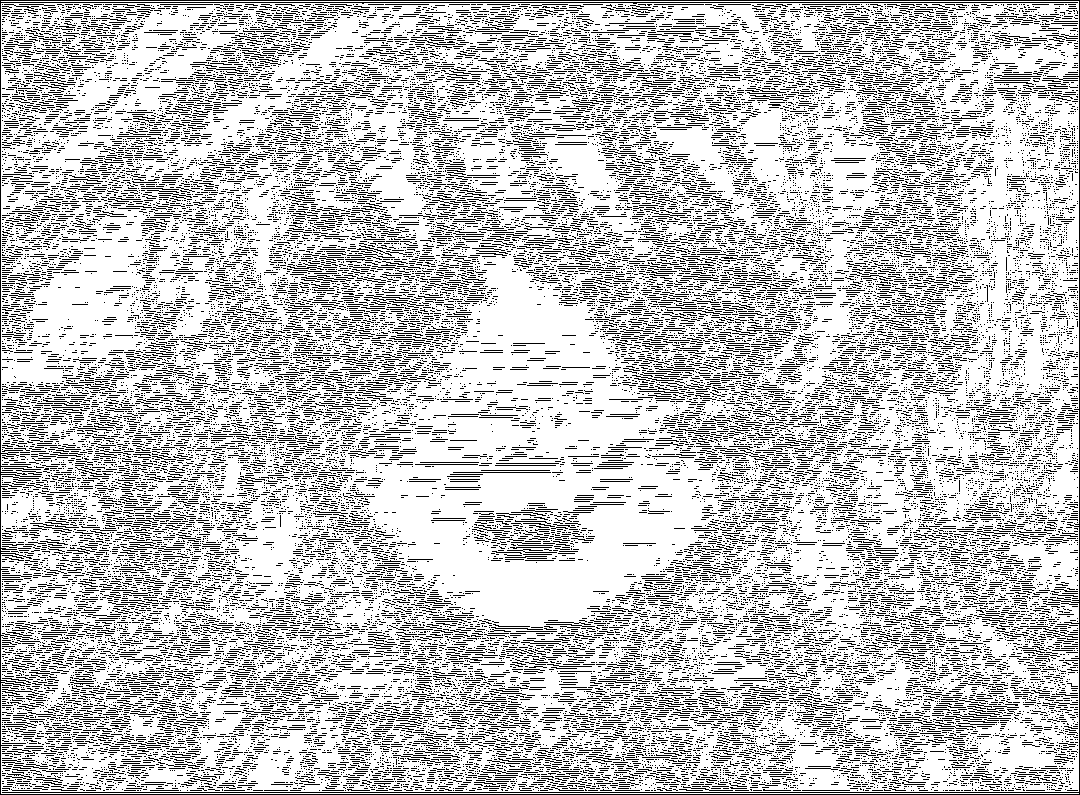

In [11]:
#test với ảnh kích thước lớn

#maTranAnh = img.open('images/input1.bmp').convert('RGB')
#maTranAnh = img.open('images/input2.gif').convert('RGB')
maTranAnh = img.open('images/input4.jpg').convert('RGB')
m,n = maTranAnh.size
u = np.sqrt(np.array(maTranAnh)[:,:,0]**2+np.array(maTranAnh)[:,:,1]**2+np.array(maTranAnh)[:,:,2]**2)
print(u.shape)
u = u/255.0/1.732*2.0-1.0
ptvp.set_initial_value((u*0.0).flatten(), 0.0)
ptvp.set_f_params(u, testB, testA, testI, n, m)
x = (ptvp.integrate(cnn.t1))[:].reshape(n, m)
y = hamDauRa(x)
y = np.sign(y)
y = (y/2.0+0.5)*255
print(f'y = {y}')
out = img.fromarray(y).convert('RGB')
out.save('images/output9.png')
print('done')
maTranAnh.show()
out